In [ ]:
!unzip '/content/drive/MyDrive/Datasets/Medicinal Plant-Bijly-1-noBG.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Medicinal Plant-Bijly-1-noBG/Test/Bohera/(37).png  
  inflating: Medicinal Plant-Bijly-1-noBG/Test/Bohera/(38).png  
  inflating: Medicinal Plant-Bijly-1-noBG/Test/Bohera/(39).png  
  inflating: Medicinal Plant-Bijly-1-noBG/Test/Bohera/(4).png  
  inflating: Medicinal Plant-Bijly-1-noBG/Test/Bohera/(40).png  
  inflating: Medicinal Plant-Bijly-1-noBG/Test/Bohera/(41).png  
  inflating: Medicinal Plant-Bijly-1-noBG/Test/Bohera/(42).png  
  inflating: Medicinal Plant-Bijly-1-noBG/Test/Bohera/(43).png  
  inflating: Medicinal Plant-Bijly-1-noBG/Test/Bohera/(44).png  
  inflating: Medicinal Plant-Bijly-1-noBG/Test/Bohera/(45).png  
  inflating: Medicinal Plant-Bijly-1-noBG/Test/Bohera/(46).png  
  inflating: Medicinal Plant-Bijly-1-noBG/Test/Bohera/(47).png  
  inflating: Medicinal Plant-Bijly-1-noBG/Test/Bohera/(48).png  
  inflating: Medicinal Plant-Bijly-1-noBG/Test/Bohera/(49).png  
  inflating: Medicinal Plant-Bijly-1-noB

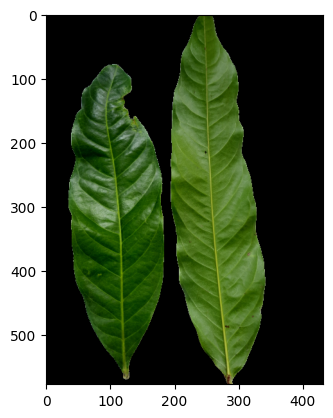

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

orig_img = np.array(load_img('/content/Medicinal Plant-Bijly-1-noBG/Train/Bohera/(102).png'),dtype=np.uint8)
plt.imshow(orig_img)
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


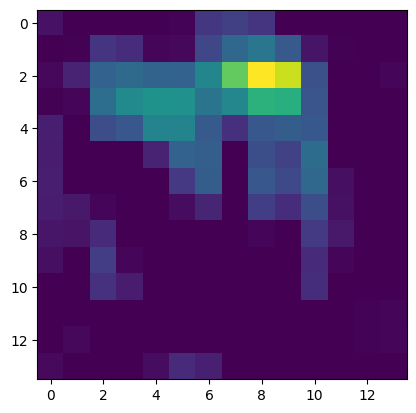

In [ ]:
############
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt

model = VGG16(include_top=True, weights='imagenet')
layer_name = 'block5_conv3'
img_array = read_and_preprocess_img('/content/Medicinal Plant-Bijly-1-noBG/Train/Bohera/(102).png', size=(224,224))

GradCam = GradCam(model,img_array,layer_name)

plt.imshow(GradCam)
plt.show()

/content/Medicinal Plant-Bijly-1-noBG/Train/Bohera/(122).png
class activation map for: ('n07714571', 'head_cabbage', 0.8476817)


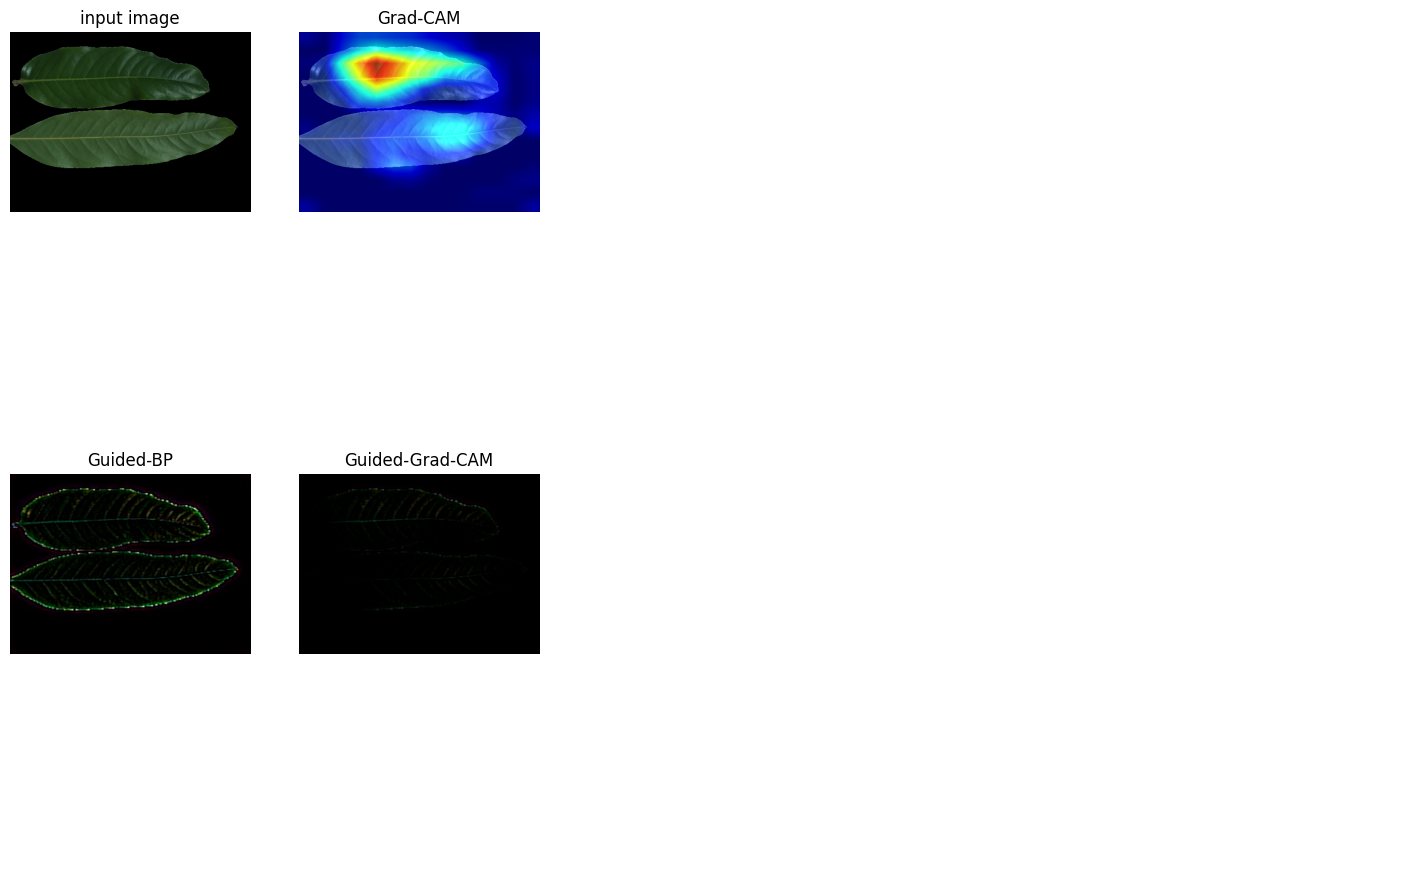

In [ ]:
# Grad-CAM,

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import cv2
import numpy as np

def build_VGG16():
    return VGG16(include_top=True, weights='imagenet')

model = build_VGG16()
layer_name = 'block5_conv3'

img_path = '/content/Medicinal Plant-Bijly-1-noBG/Train/Bohera/(122).png'
orig_img = np.array(load_img(img_path),dtype=np.uint8)
img_array = read_and_preprocess_img(img_path, size=(224,224))

predictions = model.predict(img_array)
top = decode_predictions(predictions, top=5)[0]
print(img_path)
print("class activation map for:",top[0])
### Fuctions
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import gc

tf.compat.v1.disable_eager_execution()

def normalize(x):
        """Utility function to normalize a tensor by its L2 norm"""
        return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))

    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = tf.gradients(y_c, conv_output)[0]
    # grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0

    return cam
########

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

###########

def superimpose(original_img_path, cam, emphasize=False):

    img_bgr = cv2.imread(original_img_path)

    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, 0.5, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return superimposed_img_rgb

import tensorflow.keras

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras.applications.vgg16 import preprocess_input

def build_guided_model(build_model_function):
    """Function returning modified model.

    Changes gradient function for all ReLu activations according to Guided Backpropagation.
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model_function()
    return new_model

def GuidedBackPropagation(model, img_array, layer_name):
    model_input = model.input
    layer_output = model.get_layer(layer_name).output
    max_output = K.max(layer_output, axis=3)
    grads = tf.gradients(max_output, model_input)[0]
    get_output = K.function([model_input], [grads])
    saliency = get_output([img_array])
    saliency = np.clip(saliency[0][0], 0.0, 1.0)  # scale 0 to 1.0
    return saliency

def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

from tensorflow.keras.preprocessing.image import load_img, img_to_array

def read_and_preprocess_img(path, size=(224,224)):
    img = load_img(path, target_size=size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x
grad_cam=GradCam(model,img_array,layer_name)
grad_cam_superimposed = superimpose(img_path, grad_cam)
grad_cam_emphasized = superimpose(img_path, grad_cam, emphasize=True)


guided_model = build_guided_model(build_VGG16)
saliency = GuidedBackPropagation(guided_model, img_array, layer_name)
saliency_resized = cv2.resize(saliency, (orig_img.shape[1], orig_img.shape[0]))

grad_cam_resized = cv2.resize(grad_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_grad_cam = saliency_resized * grad_cam_resized[..., np.newaxis]


img_gray = cv2.imread(img_path, 0)
dx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
dy = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
grad = np.sqrt(dx ** 2 + dy ** 2)  #
grad = cv2.dilate(grad,kernel=np.ones((5,5)), iterations=1)  #
grad -= np.min(grad)
grad /= np.max(grad)  # scale 0. to 1.

grad_times_grad_cam = grad * grad_cam_resized


fig, ax = plt.subplots(nrows=4,ncols=5, figsize=(18, 11))
ax[0,0].imshow(orig_img)
ax[0,0].set_title("input image")
ax[0,1].imshow(grad_cam_superimposed)
ax[0,1].set_title("Grad-CAM")

ax[2,0].imshow(saliency_resized)
ax[2,0].set_title("Guided-BP")
ax[2,1].imshow(guided_grad_cam)
ax[2,1].set_title("Guided-Grad-CAM")
for i in range(4):
    for j in range(5):
        ax[i,j].axis('off')
plt.show()
